In [1]:
# Deep Learning for Autonomous Driving
# Project 1: Understanding Multimodal Driving Data

In [2]:
%matplotlib inline
# do al import and given functions definitions
import os
import io
import math
import pickle
import PIL.Image
from PIL import Image
import cv2 as cv
import numpy as np
from load_data import load_data
from matplotlib import pyplot as plt
from IPython.display import clear_output, Image, display
from scipy import integrate, interpolate

# load all helper functions
import matplotlib.pyplot as plt
from os.path import dirname, abspath
import argparse
import math as m

def load_from_bin(bin_path):
    # load point cloud from a binary file
    obj = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)
    # ignore reflectivity info
    return obj[:, :3]


def depth_color(val, min_d=0, max_d=150):
    """
    print Color(HSV's H value) corresponding to distance(m)
    close distance = red , far distance = blue
    """
    np.clip(val, 0, max_d, out=val)  # max distance is 120m but usually not usual
    return (((val - min_d) / (max_d - min_d)) * 120).astype(np.uint8)


def line_color(val, min_d=1, max_d=64):
    """
    print Color(HSV's H value) corresponding to laser id
    """
    alter_num = 4
    return (((val - min_d)%alter_num) * 127/alter_num).astype(np.uint8)

def calib_velo2cam(filepath):
    """
    get Rotation(R : 3x3), Translation(T : 3x1) matrix info
    using R,T matrix, we can convert velodyne coordinates to camera coordinates
    """
    with open(filepath, "r") as f:
        file = f.readlines()

        for line in file:
            (key, val) = line.split(':', 1)
            if key == 'R':
                R = np.fromstring(val, sep=' ')
                R = R.reshape(3, 3)
            if key == 'T':
                T = np.fromstring(val, sep=' ')
                T = T.reshape(3, 1)
    return R, T


# def calib_cam2cam(filepath, mode):
#     """
#     If your image is 'rectified image' :
#         get only Projection(P : 3x4) matrix is enough
#     but if your image is 'distorted image'(not rectified image) :
#         you need undistortion step using distortion coefficients(5 : D)
#
#     in this code, we'll get P matrix since we're using rectified image.
#     in this code, we set filepath = 'yourpath/2011_09_26_drive_0029_sync/calib_cam_to_cam.txt' and mode = '02'
#     """
#     with open(filepath, "r") as f:
#         file = f.readlines()
#
#         for line in file:
#             (key, val) = line.split(':', 1)
#             if key == ('P_rect_' + mode):
#                 P_ = np.fromstring(val, sep=' ')
#                 P_ = P_.reshape(3, 4)
#                 # erase 4th column ([0,0,0])
#                 P_ = P_[:3, :3]
#     return P_

def calib_cam2cam(filepath, mode):
    """
    projection matrix from reference camera coordinates to a point on the ith camera plan
    in our case, mode is '02'
    the rectifying rotation matrix "R_rect_00" of the referece camera needs to be considered for accurate projection
    lidar to cam2: first project lidar pts to cam0 by the matrices returned by calib_velo2cam, and
    then transform the projected pts with the matrix returned by this function
    """
    with open(filepath, "r") as f:
        file = f.readlines()

        for line in file:
            (key, val) = line.split(':', 1)
            if key == ('P_rect_' + mode):
                P_ = np.fromstring(val, sep=' ')
                P_ = P_.reshape(3, 4)
                # erase 4th column ([0,0,0])
                #P_ = P_[:3, :3]
            if key == 'R_rect_00':
                R_rect_00 = np.fromstring(val, sep=' ')
                R_rect_00 = R_rect_00.reshape(3, 3)
                R_rect_00_ = np.zeros((4,4))
                R_rect_00_[:-1,:-1] = R_rect_00

    return np.matmul(P_,R_rect_00_)



def print_projection_plt(points, color, image):
    """ project converted velodyne points into camera image """

    hsv_image = cv.cvtColor(image, cv.COLOR_BGR2HSV)

    for i in range(points.shape[1]):
        cv.circle(hsv_image, (np.int32(points[0][i]), np.int32(points[1][i])), 2, (int(color[i]), 255, 255), -1)

    return cv.cvtColor(hsv_image, cv.COLOR_HSV2RGB)



def compute_timestamps(timestamps_f, ind):
    # return timestamps of the the ind^th sample (line) in seconds
    # in this code, timestamps_f can be 'image_02/timestamps.txt', 'oxts/timestamps.txt', 'velodyne_points/timestamps_start.txt', ...
    #  'velodyne_points/timestamps_end.txt',  or 'velodyne_points/timestamps.txt'. ind is the index (name) of the sample like '0000000003'
    with open(timestamps_f) as f:
        timestamps_ = f.readlines()
        #file_id = file[7:10]
        timestamps_ = timestamps_[int(ind)]
        timestamps_ = timestamps_[11:]
        timestamps_ = np.double(timestamps_[:2]) * 3600 + np.double(timestamps_[3:5]) * 60 + np.double(timestamps_[6:])
    return timestamps_



def load_oxts_velocity(oxts_f):
    # return the speed of the vehicle given the oxts file
    with open(oxts_f) as f:
        data = [list(map(np.double, line.strip().split(' '))) for line in f]
        speed_f = data[0][8]
        speed_l = data[0][9]
        speed_u = data[0][10]
    return np.array((speed_f, speed_l, speed_u))


def load_oxts_angular_rate(oxts_f):
    # return the angular rate of the vehicle given the oxts file
    with open(oxts_f) as f:
        data = [list(map(np.double, line.strip().split(' '))) for line in f]
        angular_rate_f = data[0][20]
        angular_rate_l = data[0][21]
        angular_rate_u = data[0][22]
    return angular_rate_f, angular_rate_l, angular_rate_u


    


def load_data(data_path):
    # Load data dictionary from data_path.
    with open(data_path, 'rb') as fp:
        data = pickle.load(fp)
    return data

# https://stackoverflow.com/questions/34643747/ipython-notebook-jupyter-opencv-cv2-and-plotting
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
    
# OpenCV documentation https://docs.opencv.org/master/
# Note that it's mainly written with C/C++ in mind. However, Python functions are given as well.

(-0.5, 400.5, 600.5, -0.5)

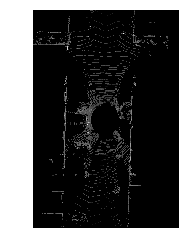

In [3]:
# Problem 1. Bird's Eye View

# load data
segmentation_data_path = os.path.join('data', 'segmentation_data.p')
segmentation_data = load_data(segmentation_data_path)

# point cloud of the scene of type (x [m], y [m], z [m], reflectance intensity [0,1]), (num_points x 4) numpy.array object
velodyne = segmentation_data["velodyne"]

def lidar2bev(lidar, resolution, front_range, side_range):
    x_lidar, y_lidar, z_lidar, r_lidar  = lidar[:,0], lidar[:,1], lidar[:,2], lidar[:,3]
    
    # Filter out points that are not in the desired box of bev view
    indices_x = np.logical_and((x_lidar >= front_range[0]), x_lidar <= front_range[1])
    indices_y = np.logical_and((y_lidar >= side_range[0]), y_lidar <= side_range[1])
    indices = np.argwhere(np.logical_and(indices_x,indices_y)).flatten()
    filtered_lidar = lidar[indices]    
    x_lidar, y_lidar, z_lidar, r_lidar = x_lidar[indices], y_lidar[indices], z_lidar[indices], r_lidar[indices]
    
    # Shift to (0,0) and divide by resolution to obtain the image coordinates
    # Note that lidar coordinates system is different than image coordinates
    # lidar: y is positive left img: y is positive right
    # lidar: x is positive forward img: x is positive down
    x_image = -np.rint((x_lidar - front_range[1]) / resolution).astype(np.int32)
    y_image = -np.rint((y_lidar - side_range[1]) / resolution).astype(np.int32)
    
    # Create the image
    width = int(((side_range[1] - side_range[0]) // resolution)) + 2
    height = int(((front_range[1] - front_range[0]) // resolution)) + 2
    image = np.zeros((height, width))
    
    # Now we want to take highest points if multiple points overlap
    # so just sort the points ascending based on x,y,z (in this order) coordinates respectively
    #later the one with highest z will always overwrite the previous ones in the for loop. 
    im_points = np.stack((x_image, y_image, z_lidar, r_lidar), axis=1)
    im_points = im_points[np.lexsort((im_points[:,2], im_points[:,1], im_points[:,0]))]
    
    x_image = im_points[:,0].astype(np.int32)
    y_image = im_points[:,1].astype(np.int32)
    r_lidar = im_points[:,3]
   
    # Iterate over all points and set the pixel intensity
    for i in range(len(x_image)):
        image[x_image[i], y_image[i]] = r_lidar[i]
    return image

# call the function with bounding box of 30 to 30
bev = lidar2bev(velodyne, 0.1, (-30,30), (-20,20))
#showarray(bev)
plt.imshow(bev, cmap='gray')
plt.axis('off')

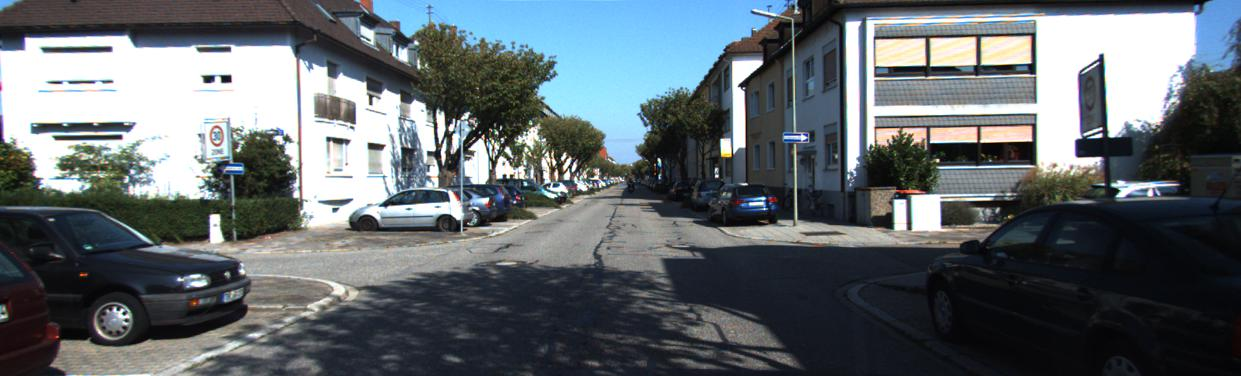

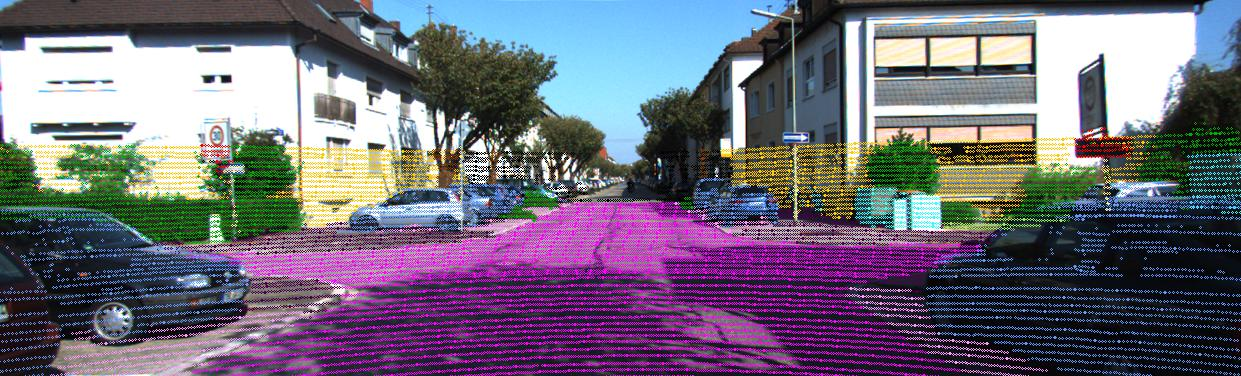

In [4]:
# Problem 2. Projection onto Image Plane
# a. Semantic Segmentation: Displaying Semantic Labels

# load data
segmentation_data_path = os.path.join('data', 'segmentation_data.p')
segmentation_data = load_data(segmentation_data_path)

# point cloud of the scene of type (x [m], y [m], z [m], reflectance intensity [0,1]), (num_points x 4) numpy.array object
velodyne = segmentation_data["velodyne"]

# RGB image received from left RGB camera (1 image per 360° velodyne rotation)
image_2 = segmentation_data["image_2"]

# intrinsic projection matrix to Cam 2 after rectification, (3x4) numpy.array object
P_rect_20 = segmentation_data["P_rect_20"]

# homogeneous velodyne to rectified camera 0 coordinate transformation, (4x4) numpy.array object
T_cam0_velo = segmentation_data["T_cam0_velo"]

# semantic label of each point within the scene, (num_points,) numpy.array object
sem_labels = segmentation_data["sem_label"]

# dictionary mapping numeric semantic labels -> BGR (reversed RGB) color for visualization (e.g. 10: [245, 150, 100])
color_map = segmentation_data["color_map"]

# dictionary mapping numeric semantic labels -> string class (e.g. 10: "car")
labels = segmentation_data["labels"]

# computer vision naming scheme:
#    X is a 3d point
#    x is a 2d point
#    Xh is a 3d homogeneous point
#    xh is a 2d homogeneous point
Xh_world = np.copy(velodyne)
Xh_world[:, 3] = 1 # overwrite intensities to homogenous cooordinates

# project the 3d homogeneous points (lidar coordinates) to 2d homogeneous points (cam2 coordinates)
Xh_rectified_cam0 = np.matmul(T_cam0_velo, np.transpose(Xh_world))
xh_rectified_cam2 = np.matmul(P_rect_20, Xh_rectified_cam0)
# normalize such that homogeneous coordinate is 1.0 again
xh_rectified_cam2 /= xh_rectified_cam2[2,:]

# prune homogeneous coordinates
x_rectified_cam2 = np.rint(xh_rectified_cam2[:2]).astype(np.int32)

# 1st index goes over each point and 2nd index goes over coordinates of the point
x_rectified_cam2 = np.transpose(x_rectified_cam2)

# make a copy to be safe
image_2_semantic_segmentation = np.copy(image_2)

# Velodyne scans are 360°, so we need to get rid of all points that are behind cam2 
# => retain only points whose x-value >= 0.27 (lidar coordinates)
# 0.27 because that is the the difference between cam2 and velodyne
indices = np.where(velodyne[:,0] >= 0.27)[0]
x_rectified_cam2 = x_rectified_cam2[indices]
sem_labels = sem_labels[indices]

# draw the velodyne points as semantic segmentation points (circles)
for i in range(len(x_rectified_cam2)) :    
    x = x_rectified_cam2[i, 0]
    y = x_rectified_cam2[i, 1]
    sem_label = sem_labels[i]
    color = color_map[sem_label[0]][::-1]

    cv.circle(img = image_2_semantic_segmentation, center = (x,y), radius = 1, color = color)

# write output and show results
cv.imwrite("image_2.png", image_2)
showarray(image_2)
cv.imwrite("image_2_semantic_segmentation.png", image_2_semantic_segmentation)
showarray(image_2_semantic_segmentation)

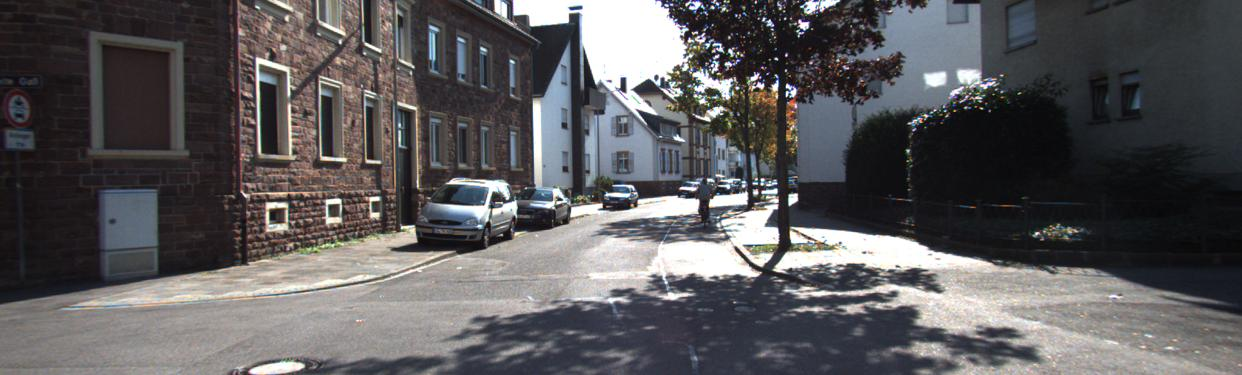

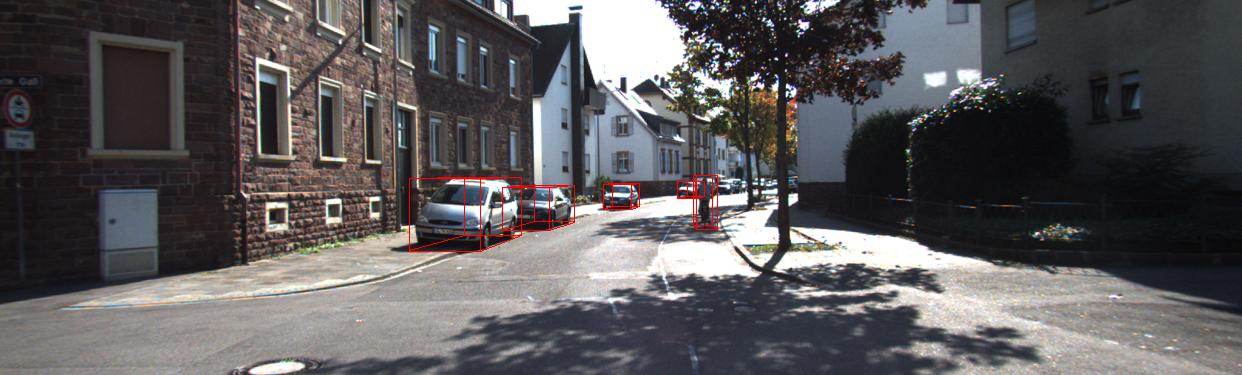

In [5]:
# Problem 2. Projection onto Image Plane
# b. Object Detection: Drawing 3D Bounding Boxes

# load data
detection_data_path = os.path.join("data", "detection_data.p")
detection_data = load_data(detection_data_path)

# RGB image received from left RGB camera (1 image per 360° velodyne rotation)
image_2 = detection_data["image_2"]

# intrinsic projection matrix to Cam 2 after rectification, (3x4) numpy.array object
P_rect_20 = detection_data["P_rect_20"]
objects = detection_data["objects"]

# pinhole camera intrinsics from Cam 0 to Cam 2, (3x3) numpy.array object
K_cam0 = detection_data["K_cam0"]
K_cam2 = detection_data["K_cam2"]


# make a copy to be safe
image_2_bounding_boxes = np.copy(image_2)

# draw the bounding boxes
for i in range(np.shape(objects)[0]) :
    # type \in {"Car", "Van", "Truck", "Pedestrian", "Person_sitting", "Cyclist", "Tram", "Misc", "DontCare"}
    obj_type = objects[i][0]

    # the task description says:
    # Project the 3d bounding boxes of all given vehicles, cyclists and pedestrians
    # within the scene of detection data.p to the Cam 2 image
    # Therefore, we assume "Misc" and "DontCare" are not supposed to be shown
    if obj_type in ("Misc", "DontCare") : continue

    # 3D object dimensions in meters, used to construct the bounding box
    height = objects[i][1]
    width  = objects[i][2] / 2
    length = objects[i][3] / 2
    
    # rotation around Y-axis in Cam 0 coordinates [-pi : pi]
    ry = objects[i][7] 
    
    # 3D object location x,y,z in Cam0 coordinates in meters, used as the center point of the bounding box
    center = np.array(objects[i][4:7])
    
    R = np.array([
        [np.cos(ry), 0, np.sin(ry)],
        [0, 1, 0],
        [-np.sin(ry), 0, np.cos(ry)]
        ]
    )
    
    # Bottom face
    corner1 = [-length, 0, -width]
    corner2 = [length, 0, -width]
    corner3 = [length, 0, width]
    corner4 = [-length, 0, width]
    
    #Upper face
    corner5 = [-length, -height, -width]
    corner6 = [length, -height, -width]
    corner7 = [length, -height, width]
    corner8 = [-length, -height, width]
    
    all_corners = np.stack((corner1, corner2, corner3, corner4, corner5, corner6, corner7, corner8), axis=1)
       
    # homogenous coordinates
    all_corners = np.matmul(R, all_corners)
    all_corners += center.reshape(-1,1)
    all_corners = np.append(all_corners, np.ones((1,8)),axis=0).T
    
    all_corners = all_corners[np.lexsort((all_corners[:,2], all_corners[:,1], all_corners[:,0]))].T
    
    
    #project points back to cam 2
    all_corners = np.matmul(P_rect_20, all_corners)
    # make homogenous
    all_corners /= all_corners[2,:]
    # prune homogenous coordinates
    all_corners = all_corners[:2].astype(np.int32)
    
    color = (255,0,0)
    color2 = (0,255,0)
    
    #plot closest face 
    cv.rectangle(img = image_2_bounding_boxes, pt1 = tuple(all_corners[:,0]), pt2 = tuple(all_corners[:,5]), color = color)
    # plot furhest face
    cv.rectangle(img = image_2_bounding_boxes, pt1 = tuple(all_corners[:,3]), pt2 = tuple(all_corners[:,6]), color = color)
    
    # draw the lines between corners
    cv.line(img = image_2_bounding_boxes, pt1 = tuple(all_corners[:,0]), pt2 = tuple(all_corners[:,2]), color = color)
    cv.line(img = image_2_bounding_boxes, pt1 = tuple(all_corners[:,4]), pt2 = tuple(all_corners[:,6]), color = color)
    cv.line(img = image_2_bounding_boxes, pt1 = tuple(all_corners[:,1]), pt2 = tuple(all_corners[:,3]), color = color)
    cv.line(img = image_2_bounding_boxes, pt1 = tuple(all_corners[:,5]), pt2 = tuple(all_corners[:,7]), color = color)
    
    
# write output and show results
cv.imwrite("image_2.png", image_2)
showarray(image_2)
cv.imwrite("image_2_bounding_boxes.png", image_2_bounding_boxes)
showarray(image_2_bounding_boxes)

0.4203125


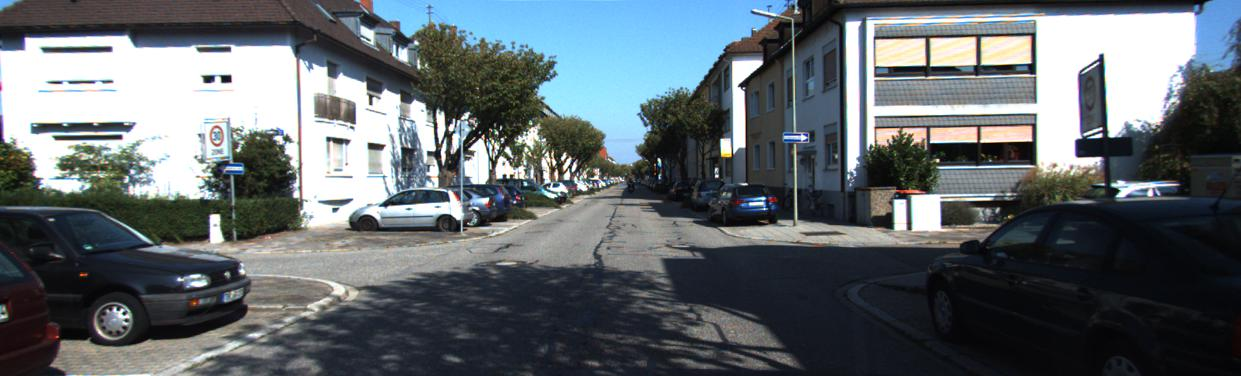

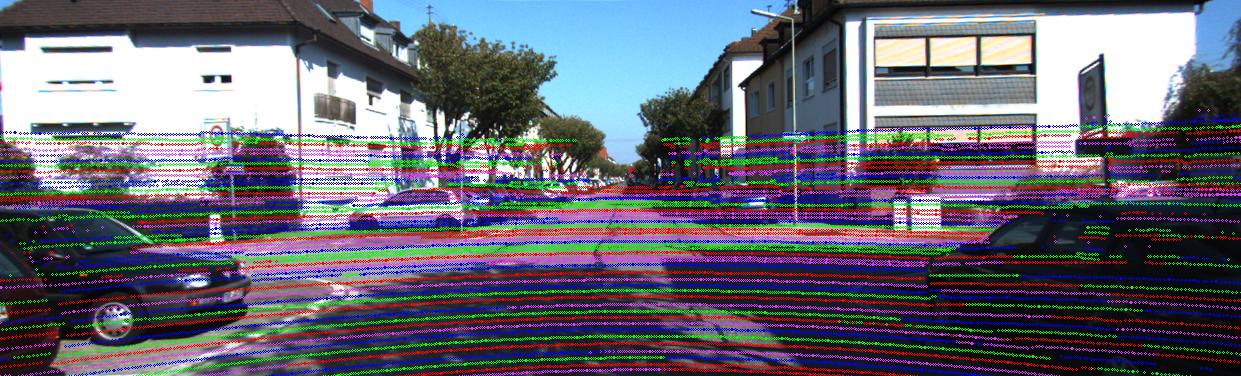

In [6]:
#Problem 3
velodyne = segmentation_data["velodyne"]
sem_labels = segmentation_data["sem_label"]
distances = np.sqrt(np.sum(np.square(velodyne), axis = 1))
image_2 = segmentation_data["image_2"]
image_2_laser_id = np.copy(image_2)

angles = 180 / np.pi * np.arcsin(velodyne[:,2]/distances).reshape(-1,1)

#fix the width
minimum = -24.9 
maximum = 2
width = (maximum-minimum) / 64

print(width)

channel = (angles-minimum+0.5*width) // width - 3
#channel = (angles - minimum) // width
color = np.mod(channel, 4)

########## Again pre processing as in previous exercise:
# project the 3d homogeneous points (world coordinates) to 3d homogeneous points (cam0 coordinates)
Xh_world = np.copy(velodyne)
Xh_world[:, 3] = 1

#from velodyne to cam0 3d
Xh_rectified_cam2 = np.matmul(T_cam0_velo, np.transpose(Xh_world))
# project the 3d homogeneous points (cam0 coordinates) to 2d homogeneous points on the rectified cam2 image plane
xh_rectified_cam2 = np.matmul(P_rect_20, Xh_rectified_cam2)

# normalize such that homogeneous coordinate is 1.0 again
xh_rectified_cam2 = xh_rectified_cam2 / xh_rectified_cam2[2,:]

# prune homogeneous coordinates
x_rectified_cam2 = xh_rectified_cam2[0:2]

# convert float32 -> int32 (implicit rounding)
x_rectified_cam2 = x_rectified_cam2.astype(np.int32)

# 1st index goes over each point and 2nd index goes over coordinates of the point
x_rectified_cam2 = np.transpose(x_rectified_cam2)
######### End pre processing

# Velodyne scans are 360°, so we need to get rid of all points that are behind cam2 
# => retain only points whose x-value >= 0.27 (lidar coordinates)
indices = np.where(velodyne[:,0] >= 0.27)[0]
x_rectified_cam2 = x_rectified_cam2[indices]
color = color[indices]

for i in range(np.shape(x_rectified_cam2)[0]) :
    x = x_rectified_cam2[i, 0]
    y = x_rectified_cam2[i, 1]
    sem_label = sem_labels[i]
    
    if color[i] == 0:
        c = (255, 0, 0)
    elif color[i] == 1:
        c = (0, 255, 0)
    elif color[i] == 2:
        c = (0, 0, 255)
    elif color[i] == 3:
        c = (230, 55, 255)
        
    cv.circle(img = image_2_laser_id, center = (x,y), radius = 1, color = c)

# write output and show results
cv.imwrite("image_2.png", image_2)
showarray(image_2)
cv.imwrite("image_2_laser_id.png", image_2_laser_id)
showarray(image_2_laser_id)

In [7]:
# Problem 4. Remove Motion Distortion

In [8]:
# index of the frame
index_name = '0000000077'
index = 77

# load calibratin data
cam2cam = calib_cam2cam('data/problem_4/calib_cam_to_cam.txt', mode = '02')
velo2cam = calib_velo2cam('data/problem_4/calib_velo_to_cam.txt')
imu2velo = calib_velo2cam('data/problem_4/calib_imu_to_velo.txt')
# transformation matrix from velodyne to cam0 3d
T = np.append(velo2cam[0], velo2cam[1], axis=1)
T = np.append(T, [[0,0,0,1]], axis = 0)

def transform2cam(point_cloud, T):
    # cam0 3d coordinates
    cam0coord3d = np.matmul(T, point_cloud.T)
    # here eliminate points in the back
    indices = np.where(cam0coord3d[2,:] > 0)[0]
    cam0coord3d = cam0coord3d[:, indices]

    # cam2 2d coordinates, normalize to homogenous and get rid of it.
    cam2coord2d = np.matmul(cam2cam, cam0coord3d)
    cam2coord2d = cam2coord2d / cam2coord2d[2, :]
    cam2coord2d = cam2coord2d[:2,:]

    distances = np.sqrt(np.sum(np.square(cam0coord3d), axis = 0))
    colormap = depth_color(distances)
    
    return cam2coord2d, colormap



### function starts here

def removeMotionDistortion(index_name, index):
    # read all the required data
    image = cv.imread('data/problem_4/image_02/data/' + index_name + '.png', )
    point_cloud = load_from_bin('data/problem_4/velodyne_points/data/' + index_name + '.bin')[:,:4]
    lidar_start = compute_timestamps('data/problem_4/velodyne_points/timestamps_start.txt', index_name)
    lidar_trigger = compute_timestamps('data/problem_4/velodyne_points/timestamps.txt', index_name)
    lidar_end = compute_timestamps('data/problem_4/velodyne_points/timestamps_end.txt', index_name)
    velocity = load_oxts_velocity('data/problem_4/oxts/data/' + index_name + '.txt')
    angular_rate = np.asarray(load_oxts_angular_rate('data/problem_4/oxts/data/' + index_name + '.txt'))
    angular_rate_z = angular_rate[2]


    # calculate the trigger angle
    trigger_angle = (lidar_trigger - lidar_start) / (lidar_end - lidar_start) * 360

    # compute angle for each point
    angles = np.arctan2(point_cloud[:,1], point_cloud[:,0]) # returns [-pi, +pi]
    #angles += np.pi

    angles = (180 / np.pi * angles) # convert to degrees
    indices = np.where(angles < 0)[0]
    angles[indices] += 360

    #angles = 180 / np.pi * angles
    #print("angles: ", angles)

    angles_relative = (angles+360-trigger_angle) % 360
    angles_relative = np.pi * angles_relative / 180

    time_point = lidar_start + (lidar_end - lidar_start) * (angles_relative / (2*np.pi))
    #print("time_point ", time_point)
    time_relative_trigger = time_point - lidar_trigger
    #print("time relative to the trigger time ", time_relative_trigger)

    # point_cloud = point_cloud + time_relative_trigger * velocity

    # make the point cloud homogenous
    point_cloud = np.append(point_cloud, np.ones((len(point_cloud), 1)), axis=1 )
    point_cloud_original = np.copy(point_cloud)

    # now iterate over the points and correct them
    for i in range(len(point_cloud)):
        point = np.copy(point_cloud[i,:])
        translation = time_relative_trigger[i] * velocity
        angle = time_relative_trigger[i] * angular_rate_z
        #angle = angle * np.pi / 180
        #angle = 0
        R = np.array([[np.cos(-angle), -np.sin(-angle), 0],
                     [np.sin(-angle), np.cos(-angle), 0],
                     [0,0,1]
                     ])
        M = np.append(R, -translation.reshape(-1,1), axis = 1)
        M = np.append(M, [[0,0,0,1]], axis=0)

        point_cloud[i,:] = np.matmul(M, point_cloud[i,:].T).T


    # now all points are corrected ! 
    # and they are in velodyne coordinates ! # project them back to cam2 coordinates !
    cam2coord2d, colormap = transform2cam(point_cloud, T)
    cam2coord2d_distortion, colormap_distortion = transform2cam(point_cloud_original, T)

    image2 = np.copy(image)
    image2 = cv.cvtColor(image2, cv.COLOR_BGR2RGB)
    showarray(image2)
    
    image_distortion = print_projection_plt(cam2coord2d_distortion, colormap_distortion, image)
    cv.imwrite("image_" + index_name + "distortion" +  ".png", image_distortion)
    showarray(image_distortion)

    image_distortion_removed = print_projection_plt(cam2coord2d, colormap, image)
    cv.imwrite("image_" + index_name + "distortion_corrected" +  ".png", image_distortion_removed)
    showarray(image_distortion_removed)







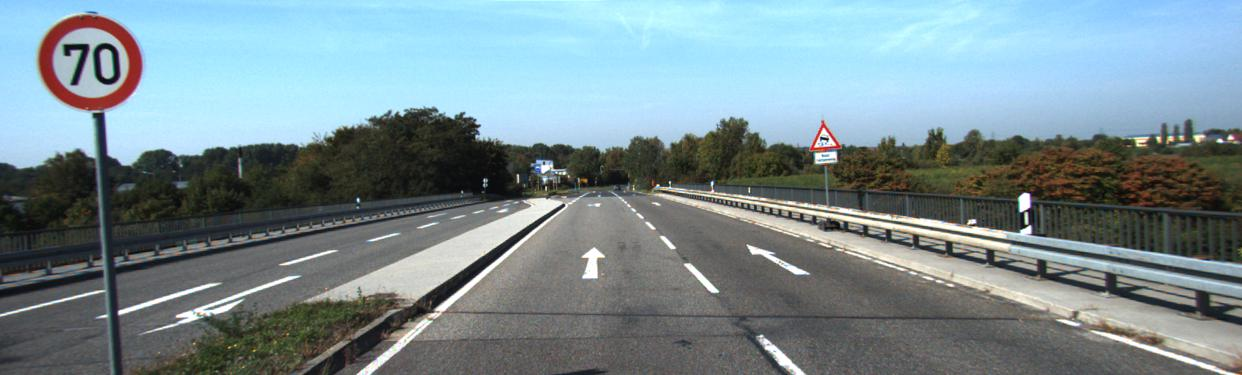

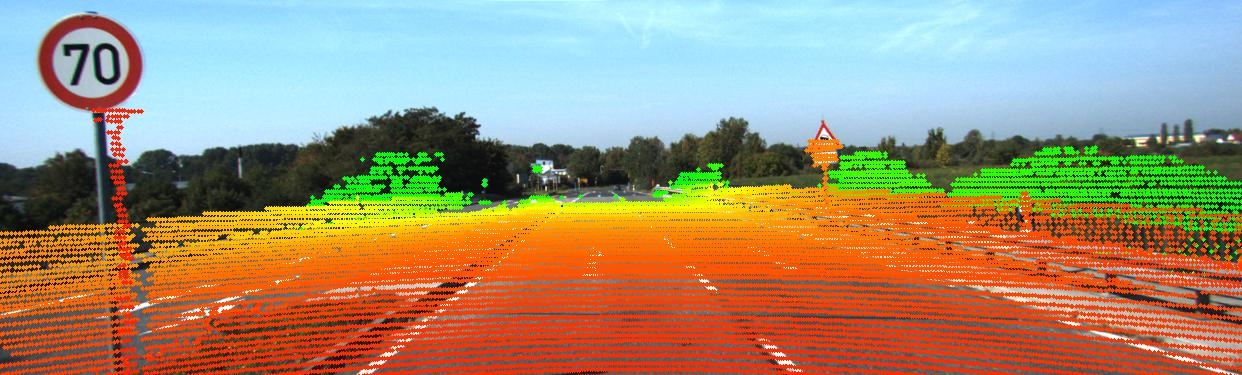

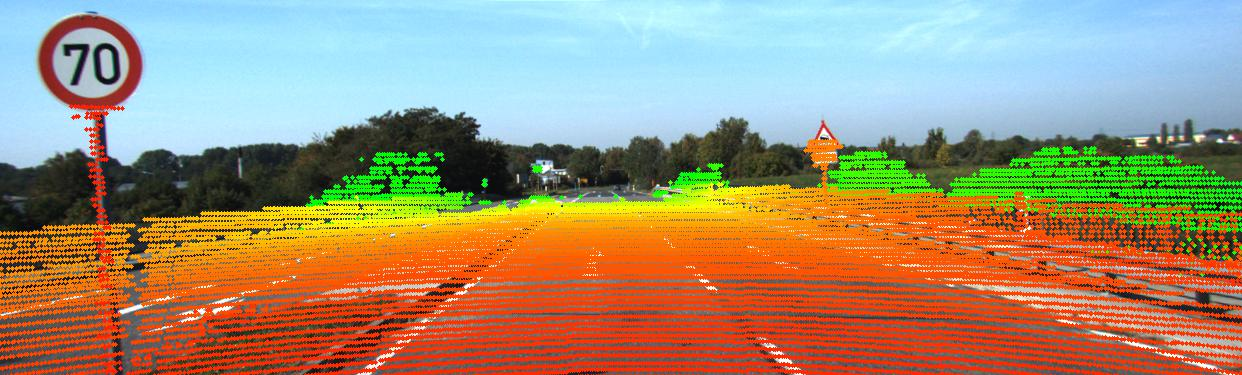

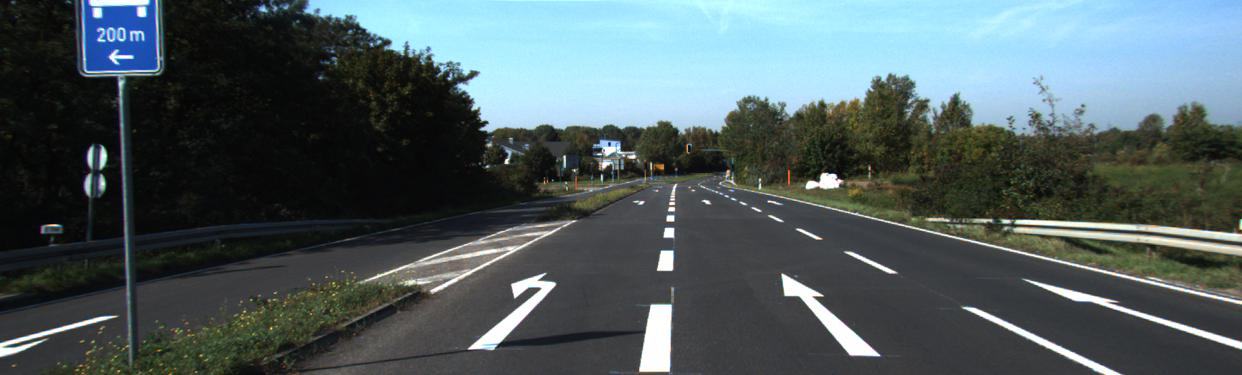

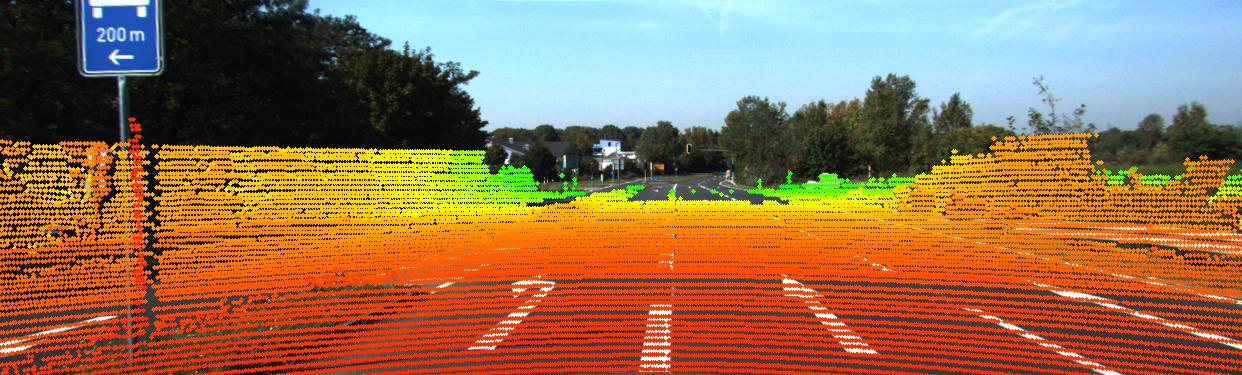

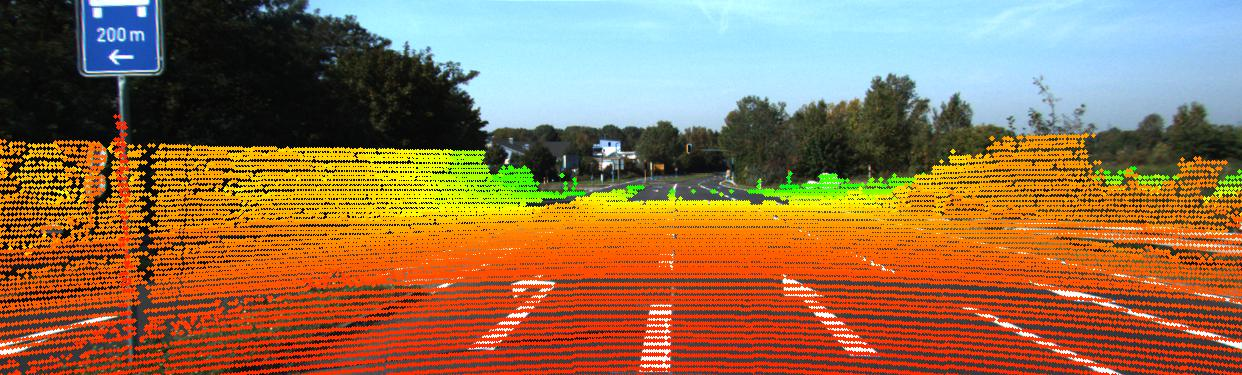

In [ ]:
indexNames = ['0000000037', '0000000077', '0000000310']
indices = [37, 77, 310]

for i in range(3):
    removeMotionDistortion(indexNames[i], indices[i])